In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 99% 668M/675M [00:07<00:00, 42.8MB/s]
100% 675M/675M [00:07<00:00, 100MB/s] 


In [6]:
! unzip cell-images-for-detecting-malaria.zip

Streaming output truncated to the last 5000 lines.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_87.png  
  inflating: cell_im

In [27]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
k = tf.keras

**TRIPLE CHECK WHERE YOUR FILES ARE DOWNLOADED AND UNZIPPED. PLEASE REVIEW VIDEO BEFORE POSTING TO QA FORUMS.**

In [8]:
my_data_dir = 'cell_images/cell_images/'

In [9]:
os.listdir(my_data_dir) 

['Uninfected', 'Parasitized']

In [10]:
! pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import splitfolders

In [12]:
import splitfolders
splitfolders.ratio(my_data_dir, output="data", seed=101, ratio=(.75, 0.0,0.25)) 

Copying files: 27560 files [00:04, 6540.54 files/s]


In [14]:
os.listdir('./data') 

['val', 'train', 'test']

In [15]:
test_path = './data/test/'
train_path = './data/train/'

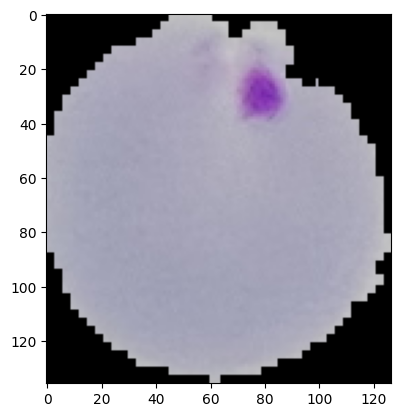

In [115]:
infected_0 = train_path + '/Parasitized/' + os.listdir(train_path + '/Parasitized')[0]
infected = plt.imread(infected_0)
plt.imshow(infected)

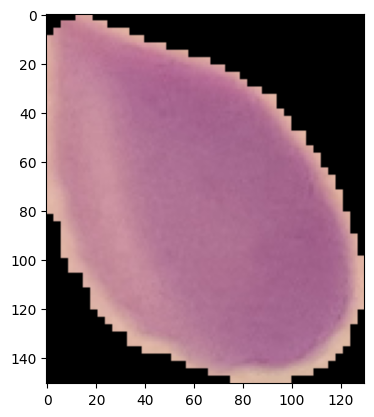

In [26]:
uninfected = plt.imread(train_path + '/Uninfected/' + os.listdir(train_path + '/Uninfected')[0])
plt.imshow(uninfected)

In [31]:
infected.max()

0.8117647

In [33]:
image_gen = k.preprocessing.image.ImageDataGenerator(
    rotation_range=20, # rotate the image 20 degrees
    width_shift_range=0.10, # Shift the pic width by a max of 5%
    height_shift_range=0.10, # Shift the pic height by a max of 5%
    # rescale=1/255, # Rescale the image by normalzing it.
    shear_range=0.1, # Shear means cutting away part of the image (max 10%)
    zoom_range=0.1, # Zoom in by 10% max
    horizontal_flip=True, # Allo horizontal flipping
    fill_mode='nearest' # Fill in missing pixels with the nearest filled value
)

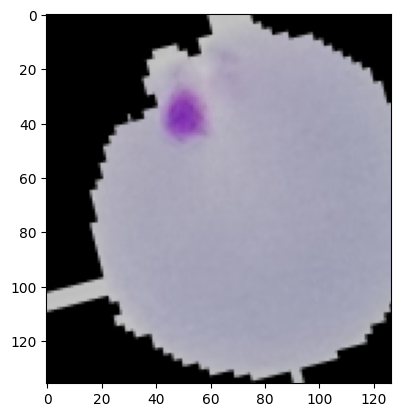

In [40]:
new_infected = image_gen.random_transform(infected)
plt.imshow(new_infected)

In [41]:
image_gen.flow_from_directory(train_path)

Found 20668 images belonging to 2 classes.


In [42]:
image_gen.flow_from_directory(test_path)

Found 6890 images belonging to 2 classes.


In [43]:
image_shape = (130, 130, 3)

# Creating the Model

In [91]:
model = k.Sequential()

model.add(k.layers.Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(k.layers.Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(k.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(k.layers.Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(k.layers.Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(k.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(k.layers.Conv2D(filters=128, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(k.layers.MaxPooling2D(pool_size=(2, 2)))


model.add(k.layers.Flatten())


model.add(k.layers.Dense(256, activation='relu'))
model.add(k.layers.Dropout(0.5))

model.add(k.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [92]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 59, 59, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 29, 29, 64)       0         
 2D)                                                  

## Early Stopping

In [93]:
early_stop = k.callbacks.EarlyStopping(monitor='val_loss',patience=2)

## Training the Model

In [95]:
batch_size = 32

In [96]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 20668 images belonging to 2 classes.


In [97]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 6890 images belonging to 2 classes.


In [98]:
train_image_gen.class_indices

{'Parasitized': 0, 'Uninfected': 1}

In [99]:
import warnings
warnings.filterwarnings('ignore')

In [100]:
results = model.fit_generator(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/20
646/646 [==============================] - 140s 211ms/step - loss: 0.4302 - accuracy: 0.8705 - val_loss: 0.1945 - val_accuracy: 0.9354
Epoch 2/20
646/646 [==============================] - 134s 208ms/step - loss: 0.2190 - accuracy: 0.9274 - val_loss: 0.1738 - val_accuracy: 0.9399
Epoch 3/20
646/646 [==============================] - 134s 207ms/step - loss: 0.2622 - accuracy: 0.9186 - val_loss: 0.1962 - val_accuracy: 0.9379
Epoch 4/20
646/646 [==============================] - 133s 206ms/step - loss: 0.1901 - accuracy: 0.9398 - val_loss: 0.1578 - val_accuracy: 0.9463
Epoch 5/20
646/646 [==============================] - 133s 205ms/step - loss: 0.1754 - accuracy: 0.9432 - val_loss: 0.1479 - val_accuracy: 0.9512
Epoch 6/20
646/646 [==============================] - 143s 221ms/step - loss: 0.1755 - accuracy: 0.9440 - val_loss: 0.1588 - val_accuracy: 0.9462
Epoch 7/20
646/646 [==============================] - 132s 205ms/step - loss: 0.1683 - accuracy: 0.9450 - val_loss: 0.1638 -

# Evaluating the Model

In [101]:
losses = pd.DataFrame(model.history.history)

<Axes: >

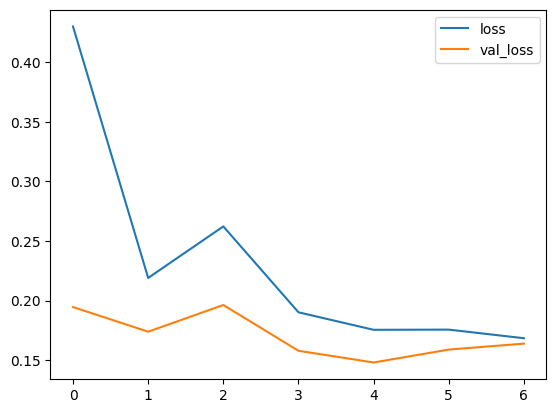

In [102]:
losses[['loss','val_loss']].plot()

In [103]:
model.metrics_names

['loss', 'accuracy']

In [104]:
model.evaluate_generator(test_image_gen)

[0.1590992510318756, 0.9465892314910889]

In [105]:
# https://datascience.stackexchange.com/questions/13894/how-to-get-predictions-with-predict-generator-on-streaming-test-data-in-keras
pred_probabilities = model.predict_generator(test_image_gen)

In [106]:
pred_probabilities

array([[2.2366876e-06],
       [9.8848110e-03],
       [1.2872694e-05],
       ...,
       [2.8297406e-01],
       [3.6371657e-01],
       [9.6799856e-01]], dtype=float32)

In [107]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [108]:
predictions = pred_probabilities > 0.5

In [109]:
# Numpy can treat this as True/False for us
predictions

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [ True]])

In [110]:
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay

In [111]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      3445
           1       0.94      0.96      0.95      3445

    accuracy                           0.95      6890
   macro avg       0.95      0.95      0.95      6890
weighted avg       0.95      0.95      0.95      6890



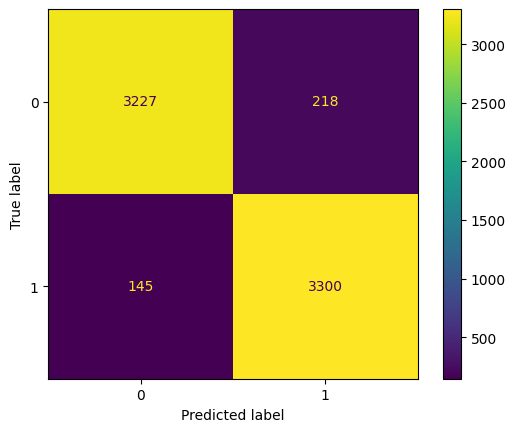

In [114]:
ConfusionMatrixDisplay(confusion_matrix(test_image_gen.classes,predictions)).plot();

# Predicting on an Image

In [116]:
my_image = k.preprocessing.image.load_img(infected_0,target_size=image_shape)

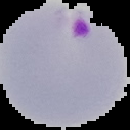

In [117]:
my_image

In [118]:
type(my_image)

PIL.Image.Image

In [119]:
my_image = k.preprocessing.image.img_to_array(my_image)

In [120]:
type(my_image)

numpy.ndarray

In [121]:
my_image.shape

(130, 130, 3)

In [122]:
my_image = np.expand_dims(my_image, axis=0)

In [123]:
my_image.shape

(1, 130, 130, 3)

In [124]:
model.predict(my_image)

1/1 [==============================] - 0s 337ms/step


array([[0.0010242]], dtype=float32)

In [125]:
train_image_gen.class_indices

{'Parasitized': 0, 'Uninfected': 1}